80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Iteration 0: Loss=813820736.0000
Iteration 100: Loss=3525483.5000
Iteration 200: Loss=2309899.5000
Iteration 300: Loss=1866191.7500
Iteration 400: Loss=1627280.2500


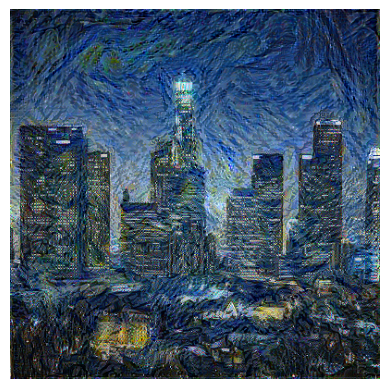

In [ ]:
# Yash Thakur (B-75)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import backend as K

# Helper functions
def load_and_process_img(path_to_img):
    img = kp_image.load_img(path_to_img, target_size=(400, 400))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def show_img(img):
    img = deprocess_img(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Load content and style images
content_path = '/content/content.jpg'  # <<< your content image here
style_path = '/content/style.jpg'      # <<< your style image here

content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)

# Define layers for style and content
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Load pre-trained VGG19 model
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return Model(vgg.input, model_outputs)

# Compute content and style features
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

# Compute Gram matrix (for style)
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

# Define loss functions
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Style loss
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_matrix(comb_style) - target_style))

    # Content loss
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content - target_content))

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    return loss

# Optimization
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Run style transfer
def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=5.0)

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        if all_loss < best_loss:
            best_loss = all_loss
            best_img = init_image.numpy()

        if i % 100 == 0:
            print(f"Iteration {i}: Loss={all_loss:.4f}")

    return best_img, best_loss

# Run
best_img, best_loss = run_style_transfer(content_path, style_path, num_iterations=500)
show_img(best_img)
